In [1]:
import os
from diffsky.experimental.disk_bulge_modeling.generate_bulge_disk_sample import (
    get_bulge_disk_test_sample,
    get_bulge_disk_decomposition,
)
from diffsky.experimental.disk_bulge_modeling.disk_bulge_kernels import (
    get_observed_quantity_pop,
)

from diffaux.validation.plot_utilities import (
    get_zindexes,
)

from diffaux.size_modeling.fit_size_data import (
    generate_sizes,
    get_median_sizes,
    Samples_zFit,
    get_color_mask,
    median_size_vs_z,
    _sigmoid,
)

from jax import random as jran
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict, namedtuple
from itertools import zip_longest

In [2]:
ran_key = jran.key(0)
halo_key, ran_key = jran.split(ran_key, 2)
lgmp_min = 11.0
redshift = 0.05
Lbox = 75.0
diffstar_cens = get_bulge_disk_test_sample(halo_key, lgmp_min=lgmp_min, redshift=redshift, Lbox=Lbox)
print(list(diffstar_cens.keys()))

Generated data shape =  (6439, 100)
['subcat', 't_table', 't_obs', 'sfh', 'smh', 'mc_quenched', 'sfh_params', 'logsm_obs', 'logssfr_obs', 'sfh_ms', 'sfh_q', 'frac_q', 'sfh_params_ms', 'sfh_params_q', 'sSFR', 'z_table']


In [3]:
zvalues = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
redshifts = diffstar_cens["z_table"]
zindexes, zs = get_zindexes(zvalues, redshifts)

In [4]:
disk_bulge_key, ran_key = jran.split(ran_key, 2)
diffstar_cens = get_bulge_disk_decomposition(disk_bulge_key, diffstar_cens)
print(diffstar_cens.keys())

dict_keys(['subcat', 't_table', 't_obs', 'sfh', 'smh', 'mc_quenched', 'sfh_params', 'logsm_obs', 'logssfr_obs', 'sfh_ms', 'sfh_q', 'frac_q', 'sfh_params_ms', 'sfh_params_q', 'sSFR', 'z_table', 'tcrit_bulge', 'fbulge_early', 'fbulge_late', 'bth', 'eff_bulge', 'sfh_bulge', 'smh_bulge', 'sSFR_bulge', 'smh_disk', 'sfh_disk', 'sSFR_disk'])


In [5]:
# get observed disk and bulge masses
tarr = diffstar_cens["t_table"]
tobs = jnp.full(len(diffstar_cens["logsm_obs"]), diffstar_cens["t_obs"])
zobs = jnp.full(len(diffstar_cens["logsm_obs"]), redshift)
bulge_sm_obs = get_observed_quantity_pop(tobs, tarr, diffstar_cens["smh_bulge"])
disk_sm_obs = np.power(10, diffstar_cens["logsm_obs"]) - bulge_sm_obs
print(Samples_zFit)
print(np.min(np.log10(bulge_sm_obs)), np.max(np.log10(bulge_sm_obs)))
print(np.min(np.log10(disk_sm_obs)), np.max(np.log10(disk_sm_obs)))

['Starforming', 'Quiescent']
7.616429241929769 11.431442428137805
7.597940549075805 11.163552909420831


In [6]:
# set up redshift and fake color arrays
zobs = jnp.full(len(diffstar_cens["logsm_obs"]), redshift)
disk_color = np.random.uniform(low=-0.2, high=1.45, size=len(diffstar_cens["logsm_obs"]))
bulge_color = np.random.uniform(low=1.55, high=2.5, size=len(diffstar_cens["logsm_obs"]))

In [8]:
from diffaux.size_modeling.fit_size_data import read_fit_parameters, zFitParameters
fit_pars, fits = read_fit_parameters(zFitParameters)
print(fit_pars)

Assembling zFitParameters from fit values for parameters B_Starforming, beta_Starforming, B_Quiescent, beta_Quiescent
zFitParameters(B_Starforming=array([11.08083014,  4.79598826,  4.14376663, 20.25107251]), beta_Starforming=array([10.91672546, 11.91362628,  0.3652059 ,  1.19675983]), B_Quiescent=array([11.04919805,  3.44065102,  1.67153891, 17.0813554 ]), beta_Quiescent=array([10.1800515 ,  6.00703528,  0.13967383,  1.28189666]))


In [17]:
#disk sizes
Re = {}
R_med = {}
labels = ['Disk', 'Bulge']
masses = [disk_sm_obs, bulge_sm_obs]
colors = [disk_color, bulge_color]
for l, sample, mass, color in zip(labels, Samples_zFit, masses, colors):
    Re[l], R_med[l] = generate_sizes(
    fit_pars, jnp.log10(mass), zobs, color, samples=[sample], fit_type="Re_vs_z",
)
    print(l)
    maske = np.isfinite(Re[l])
    maskm = np.isfinite(R_med[l])
    print(np.count_nonzero(maske), np.count_nonzero(maske))
    print(np.min(R_med[l]), np.max(R_med[l]))
    print(np.min(Re[l]), np.max(Re[l]))
#bulge sizes

Disk
6439 6439
4.070585915963302 13.019605647140768
1.0296670825711989 16.624153411936238
Bulge
6439 6439
1.6603001752580415 12.982776516620708
0.5290894701304759 17.28331336736122


In [18]:
from importlib.resources import files
SIZE_DATA_DIR = files("diffaux").joinpath("data/GalaxySizes/zhang_2019")
fn = "Zhang_et_al_2019_Size_Morphology.txt"
data = np.genfromtxt(os.path.join(SIZE_DATA_DIR, fn), skip_header=2,
                      dtype=[('type', 'U12'), ('alpha', float), ('beta', float),
                             ('gamma', float), ('M0', float)],
                      names=True,
                     )
print(data)
keys = [str(data[k][0]) for k in range(len(data))]
zhang = dict(zip(keys , [[float(data[k][l]) for l in range(1, len(data[k]))] for k in range(len(data))]))
print(zhang['late'])

def zhang_et_al_fit(M, alpha, beta, gamma, M0, h=0.678):
    #correct M to units of Msun/h**2
    M = M/(h*h)
    return gamma*(M/M0)**alpha * (1 + M/M0)**(beta-alpha)

Mtest = np.logspace(7.5, 11.5, 8)
print(Mtest)
for k, v in zhang.items():
    print(k, zhang_et_al_fit(Mtest, *v))

[('early',  0.11, 0.6 ,  1.75, 1.35e+10)
 ('late',  0.22, 1.24,  8.83, 4.49e+11)
 ('elliptical',  0.13, 0.68,  2.23, 2.96e+10)
 ('spiral',  0.16, 5.41,  8.96, 1.93e+12)
 ('quiescent', -0.02, 0.65,  1.58, 1.11e+10)
 ('star-forming',  0.23, 0.41, 10.72, 4.90e+11)
 ('B/T<0.5',  0.14, 0.71,  1.53, 1.72e+10)
 ('B/T>0.5',  0.18, 0.78,  6.34, 1.57e+11)]
[0.22, 1.24, 8.83, 449000000000.0]
[3.16227766e+07 1.17876863e+08 4.39397056e+08 1.63789371e+09
 6.10540230e+09 2.27584593e+10 8.48342898e+10 3.16227766e+11]
early [ 0.98155003  1.14206866  1.35239383  1.69530132  2.44363769  4.2949684
  8.70019266 18.6852035 ]
late [ 1.27877256  1.70880556  2.28610443  3.07163595  4.19272319  6.04828153
 10.31658133 25.01959825]
elliptical [ 1.01501324  1.2085464   1.45237996  1.80270282  2.46376592  4.09410858
  8.40069188 19.38281704]
spiral [ 1.74063057  2.14959592  2.65834557  3.30458174  4.18770944  5.69533149
  9.94063798 37.64645663]
quiescent [ 1.75634774  1.72993505  1.75384889  1.94774292  2.6672601

Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulgeSizes/Disk_Bulge_Re_vs_Mstar_z_0.05.png


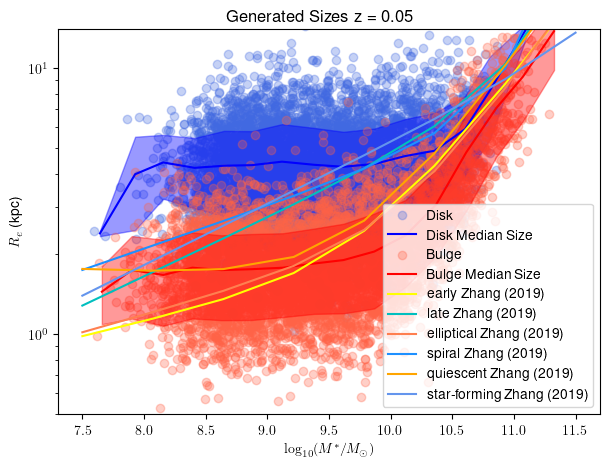

In [25]:
plotdir = "/Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulgeSizes"
from diffaux.validation.plot_utilities import get_nrow_ncol, save_fig
from scipy.stats import binned_statistic
lMbins = np.linspace(7.5, 11.5, 17)
nrow = 1
ncol =1
fit_colors = ('yellow', 'c', 'coral', 'dodgerblue', 'orange', 'cornflowerblue')
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
for l, mass, c, cpts in zip(labels, masses, ('blue', 'r'), ("royalblue", "tomato")):
    logM = np.log10(mass)
    lM,_,_ = binned_statistic(logM, logM, statistic='mean', bins=lMbins)
    mask = np.isfinite(lM)
    y,_,_ = binned_statistic(logM, Re[l], statistic='mean', bins=lMbins)
    std,_,_ = binned_statistic(logM, Re[l], statistic='std', bins=lMbins)
    ax.scatter(logM, Re[l], alpha=0.3, color=cpts, label='{}'.format(l))
    ax.plot(lM[mask], y[mask], label='{} Median Size'.format(l), color=c)
    ax.fill_between(lM, y-std, y+std, color=c, alpha=0.4)

for (k, v), f in zip(zhang.items(), fit_colors):
        if 'B/T' not in k:
            ax.plot(np.log10(Mtest), zhang_et_al_fit(Mtest, *v), label='{} Zhang (2019)'.format(k), color=f)
            
    
ax.set_xlabel('$\\log_{10}(M^*/M_\\odot)$')
ax.set_ylabel('$R_e$ (kpc)')
ax.set_yscale('log')
ax.set_ylim(0.5, 14.)
ax.legend(loc='best')


fig.suptitle("Generated Sizes z = {:.2f}".format(redshift), y=0.92, fontweight="bold")
pltname = "Disk_Bulge_Re_vs_Mstar_z_{:.2f}.png".format(redshift)
save_fig(fig, plotdir, pltname)
    

In [21]:
# Now assign sizes to whole galaxy and plot based on B/T cut
# galaxy sizes
B_over_T_obs = get_observed_quantity_pop(tobs, tarr, diffstar_cens['bth'])
bmask = B_over_T_obs <= 0.5
logM_BT = [diffstar_cens['logsm_obs'][bmask], diffstar_cens['logsm_obs'][~bmask]]
#assign color based on B/T
color_BT = np.zeros(len(diffstar_cens['logsm_obs']))
color_BT[bmask] = disk_color[bmask]
color_BT[~bmask] = bulge_color[~bmask]

Re_BT, R_med_BT = generate_sizes(
    fit_pars, diffstar_cens['logsm_obs'], zobs, color_BT, samples=Samples_zFit, fit_type="Re_vs_z",
)

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

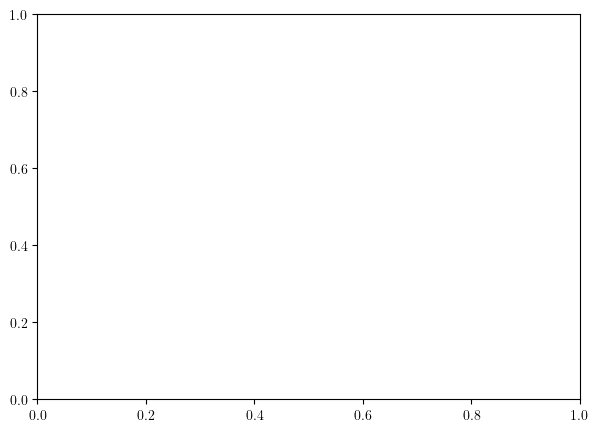

In [23]:
# plot
logM_BT = [diffstar_cens['logsm_obs'][bmask], diffstar_cens['logsm_obs'][~bmask]]
lMbins = np.linspace(7.5, 11.5, 17)
nrow = 1
ncol =1
fit_colors = ('darkorange', 'c')
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
for sample, logM, c, cpts in zip(Samples_zFit, logM_BT, ('blue', 'r'), ("royalblue", "tomato")):
    lM,_,_ = binned_statistic(logM, logM, statistic='mean', bins=lMbins)
    mask = np.isfinite(lM)
    y,_,_ = binned_statistic(logM, Re[l], statistic='mean', bins=lMbins)
    std,_,_ = binned_statistic(logM, Re[l], statistic='std', bins=lMbins)
    ax.scatter(logM, Re[l], alpha=0.3, color=cpts, label='{}'.format(l))
    ax.plot(lM[mask], y[mask], label='{} Median Size'.format(l), color=c)
    ax.fill_between(lM, y-std, y+std, color=c, alpha=0.4)

for (k, v), f in zip(zhang.items(), fit_colors):
        if 'B/T' in k:
            ax.plot(np.log10(Mtest), zhang_et_al_fit(Mtest, *v), label='{} Zhang (2018)'.format(k), color=f)
            
    
ax.set_xlabel('$\\log_{10}(M^*/M_\\odot)$')
ax.set_ylabel('$R_e$ (kpc)')
ax.set_ylim(0.5, 14.)
ax.legend(loc='best')


fig.suptitle("Generated Sizes z = {:.2f}".format(redshift), y=0.92, fontweight="bold")
pltname = "Disk_Bulge_Re_vs_Mstar_z_{:.2f}.png".format(redshift)
save_fig(fig, plotdir, pltname)